# Intensity Dependent Photoluminescence (IDPL) Analysis

In [45]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from IPython.display import display
import os
from scipy.optimize import curve_fit

### Importing IDPL data

,C,C+B,C+P,CW,NS,NS+P,P,P+P,PS,PS+P
10,C_idpl_10_.txt,C+B_idpl_10_.txt,C+P_idpl_10_.txt,CW_idpl_10_.txt,NS_idpl_10_.txt,NS+P_idpl_10_.txt,P_idpl_10_1.txt,P+P_idpl_10_.txt,PS_idpl_10_.txt,PS+P_idpl_10_.txt
25,C_idpl_25_.txt,C+B_idpl_25_.txt,C+P_idpl_25_.txt,CW_idpl_25_.txt,NS_idpl_25_.txt,NS+P_idpl_25_.txt,P_idpl_25_.txt,P+P_idpl_25_.txt,PS_idpl_25_.txt,PS+P_idpl_25.txt
50,C_idpl_50_.txt,C+B_idpl_50_.txt,C+P_idpl_50_.txt,CW_idpl_50_.txt,NS_idpl_50_.txt,NS+P_idpl_50_.txt,P_idpl_50_.txt,P+P_idpl_50_.txt,PS_idpl_50_.txt,PS+P_idpl_50_.txt
75,C_idpl_75_.txt,C+B_idpl_75_.txt,C+P_idpl_75_.txt,CW_idpl_75_.txt,NaN,NS+P_idpl_75_.txt,P_idpl_75_.txt,P+P_idpl_75_.txt,PS_idpl_75_.txt,PS+P_idpl_75_.txt
100,C_idpl_100_.txt,C+B_idpl_100_.txt,C+P_idpl_100_.txt,CW_idpl_100_.txt,NS_idpl_100_.txt,NS+P_idpl_100_.txt,P_idpl_100_.txt,P+P_idpl_100_.txt,PS_idpl_100_.txt,PS+P_idpl_100_.txt
125,C_idpl_125_.txt,C+B_idpl_125_.txt,C+P_idpl_125_.txt,CW_idpl_125_.txt,NS_idpl_125_.txt,NS+P_idpl_125_.txt,P_idpl_125_.txt,P+P_idpl_125_.txt,PS_idpl_125_.txt,PS+P_idpl_125_.txt
150,C_idpl_150_.txt,C+B_idpl_150_.txt,C+P_idpl_150_.txt,CW_idpl_150_.txt,NS_idpl_150_.txt,NS+P_idpl_150_.txt,P_idpl_150_.txt,P+P_idpl_150_.txt,PS_idpl_150_.txt,PS+P_idpl_150_.txt


,C_pk,C_infl,C+B_pk,C+B_infl,C+P_pk,C+P_infl,CW_pk,CW_infl,NS_pk,NS_infl,NS+P_pk,NS+P_infl,P_pk,P_infl,P+P_pk,P+P_infl,PS_pk,PS_infl,PS+P_pk,PS+P_infl
10,893.790085,873.031386,852.257529,829.430531,894.733292,862.961067,892.218001,863.905309,895.362078,859.498585,893.161262,867.681968,882.469075,859.813373,891.589142,861.072491,886.243261,843.804261,882.469075,859.183793
25,891.903573,862.331555,851.627788,820.990685,893.161262,863.905309,889.702479,862.961067,894.104491,868.311363,891.274707,862.331555,873.975297,852.257529,892.218001,862.331555,884.041715,847.865176,880.267231,859.498585
50,889.388023,862.331555,847.865176,816.613587,891.274707,862.961067,886.243261,859.813373,891.274707,859.183793,888.759099,859.813373,873.660663,849.426920,889.388023,861.072491,880.896347,843.491860,876.492239,851.627788
75,889.073563,861.387262,844.429053,810.985016,889.073563,862.961067,883.098142,859.498585,NaN,NaN,884.041715,859.183793,870.828806,848.489883,888.759099,861.072491,879.323530,843.491860,874.919176,844.741444
100,888.444632,858.868998,840.992539,807.544855,886.243261,859.813373,879.638101,847.865176,888.444632,859.183793,880.581791,858.868998,869.570112,847.240455,885.928765,860.442939,873.346026,835.993284,870.199466,844.741444
125,885.299763,858.554200,836.305761,806.919333,882.469075,860.442939,873.346026,844.429053,885.928765,859.183793,876.806841,847.865176,868.626055,825.367183,883.727194,860.442939,871.143470,835.368319,870.199466,845.366216
150,885.299763,858.554200,835.680803,803.165949,880.581791,859.813373,871.143470,844.429053,885.299763,858.868998,871.458132,844.429053,865.793700,825.679767,882.783610,856.980158,869.255430,833.180845,865.164250,829.430531


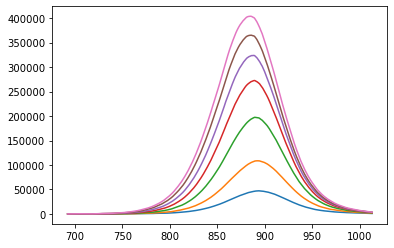

In [21]:
from scipy.signal import savgol_filter

def sort(val):
    return int(val.split('_')[2].strip('.txt'))

power=[
    '10',
    '25',
    '50',
    '75',
    '100',
    '125',
    '150']

path='FASnI3\\0607_all\\'

folderlist=[file for file in os.listdir(path) if (os.path.isfile(path+file)==False and file!='UVvis')]
flist=pd.DataFrame()

for folname in folderlist:
    pow=[]
    filelist=[file for file in os.listdir(path+folname) if 'idpl' in file]
    for f in filelist:
        pow.append(int(f.split('_')[2].strip('.txt')))
    pow.sort()
    filelist.sort(key=sort)
    filelist=pd.Series(filelist,index=pow)
    flist[folname]=filelist

display(flist)

PLmaster=pd.DataFrame(index=power)
    
for fol in folderlist:
    PLdf=pd.DataFrame()
    collection_pk=[]
    collection_infl=[]
    for p in power:
        if pd.isna(flist[fol][int(p)]):
            collection_pk.append(np.nan)
            collection_infl.append(np.nan)
            continue
        PLdata=pd.read_csv(path+fol+'\\'+str(flist[fol][int(p)]),header=None,names=['nm','intensity'],sep="\t")
        wav=pd.Series(PLdata['nm'],dtype=float)
        PLint=pd.Series(PLdata['intensity'],dtype=float)
        # rolling average smoothing + background subtracting
        PLint = PLint.iloc[:].rolling(window=20).mean().fillna(method='bfill')
        PLint = PLint.sub(PLint.min())
        # normalizing PL and adding to dataframe
        PLnorm=[]
        for i in range(len(PLint)):
            PLnorm.append((PLint[i]-PLint.min())/(PLint.max()-PLint.min()))
        PLnorm=pd.Series(PLnorm)

        if fol=='C':
            plt.plot(wav,PLint)
        
        ### find peak and peak index
        collection_pk.append(wav.iloc[PLnorm.idxmax()])
        
        ### find inflection point
        diffPL=PLnorm.copy()
        diffPL=diffPL.diff(periods=1).dropna()
        diffPL=diffPL.iloc[:].rolling(window=20).mean().fillna(method='bfill')
        collection_infl.append(wav.iloc[diffPL.idxmax()])
            
    PLmaster[fol+'_pk']=collection_pk
    PLmaster[fol+'_infl']=collection_infl

display(PLmaster)


In [25]:
avg=[]
for j in PLmaster:
    if '_infl' in j and '+B' not in j:
        avg.append(PLmaster[j]['100'])
print(avg)
print(pd.Series(avg).mean())

[760.053471401934]
760.053471401934


### Plotting IDPL extracted parameters

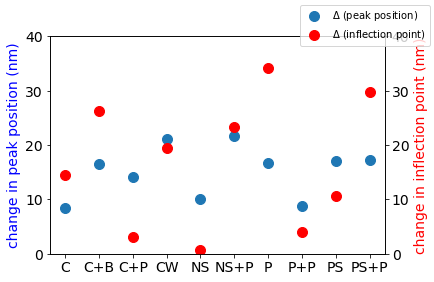

In [9]:
# plotting peak position change (nm) and inflection peak position change (nm) for each sample

delpeak=[]
delinfl=[]

for series in PLmaster: 
    if series.endswith('_pk'):
        delpeak.append(PLmaster[series][0]-PLmaster[series][-1])
    elif series.endswith('_infl'):
        delinfl.append(PLmaster[series][0]-PLmaster[series][-1])

deldf=pd.DataFrame([delpeak,delinfl],index=['delpeak','delinfl'],columns=folderlist)

deldf=deldf.transpose()
# display(deldf)
# deldf.to_csv(path+'idpl_analysis.csv',index=folderlist)

fig,ax=plt.subplots()
## peak change
ax.scatter(deldf.index.values,deldf['delpeak'].values,label=r'$\Delta$'+' (peak position)',s=100)
ax.set_ylim(0,40)
ax.set_ylabel('change in peak position (nm)',c='blue',fontsize=14)
ax.tick_params(labelsize=14)

# inflection point change
ax2=ax.twinx()
ax2.scatter(deldf.index.values,deldf['delinfl'].values,c='red',label=r'$\Delta$'+' (inflection point)',s=100)
ax2.set_ylim(0,40)
ax2.set_ylabel('change in inflection point (nm)',c='red',fontsize=14)
ax2.tick_params(labelsize=14)

fig.legend()

# fig.savefig('FASnI3\\0502_PEASCN\\'+'IDPLchange.png',dpi=300,bbox_inches='tight')

<ipython-input-150-0257052fe138>:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  TC_del=pd.Series(index=folderlist,name='TC_del')
<ipython-input-150-0257052fe138>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  TC_high=pd.Series(index=folderlist,name='TC_high')
<ipython-input-150-0257052fe138>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  TC_low=pd.Series(index=folderlist,name='TC_low')


C
10: 506.216626184764
25: 437.0673884252996
50: 425.3943337579298
75: 431.98690514535747
100: 443.3341847122006
125: 458.24458845594444
150: 471.4913061241823


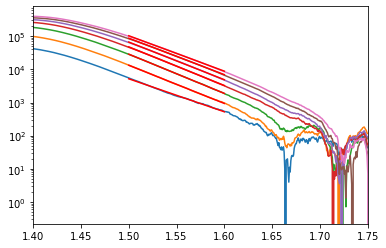

C+B
10: 427.0753527743017
25: 436.60012673160213
50: 458.6542640395318
75: 481.3010810598973
100: 503.6805171576096
125: 525.6685592469901
150: 553.3802868719769


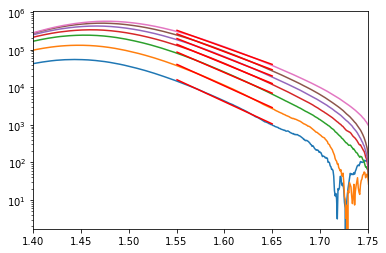

C+P
10: 406.02515324453816
25: 395.8787835623436
50: 398.12911639629937
75: 403.7669507491651
100: 416.6839113382334
125: 428.4514564222493
150: 439.96211991451685


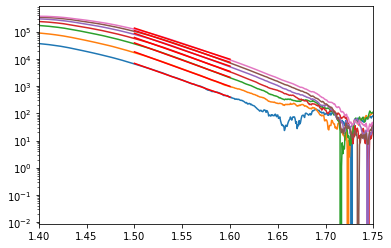

CW
10: 475.4065649019911
25: 431.5309283604485
50: 433.4551433152903
75: 450.4948383695608
100: 473.5164735619822
125: 496.6189590766977
150: 522.4356271851133


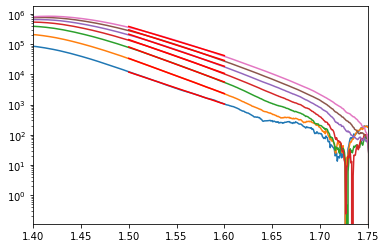

NS
10: 442.05304709819404
25: 409.2361014644087
50: 403.0043641977175
100: 420.08795764806183
125: 432.65628703720455
150: 444.9588167057217


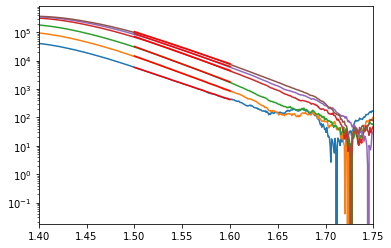

NS+P
10: 420.9148762403109
25: 374.63277684362475
50: 387.9865976314595
75: 405.62670064971303
100: 425.3987692196149
125: 447.4067982229112
150: 473.2597790702365


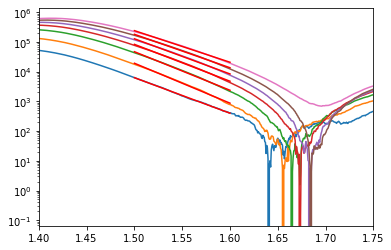

P
10: 574.7622393774274
25: 491.96257816014923
50: 456.9637428019687
75: 461.6285624930809
100: 471.81464202872706
125: 486.72685870282885
150: 512.5512268968387


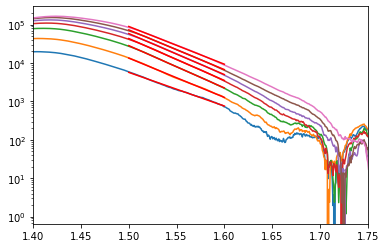

P+P
10: 445.3421111364458
25: 410.8880309535739
50: 408.0432464330409
75: 419.5343209667152
100: 429.68303815292455
125: 446.7522931810784
150: 462.3876720986967


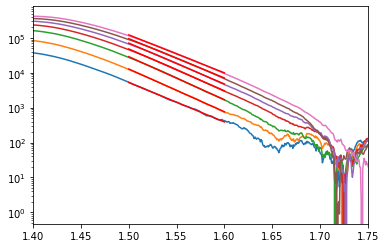

PS
10: 397.8139692406869
25: 414.4176438325579
50: 424.72837858335
75: 435.21481402252124
100: 449.7771998015072
125: 466.8441350451218
150: 483.43042349565064


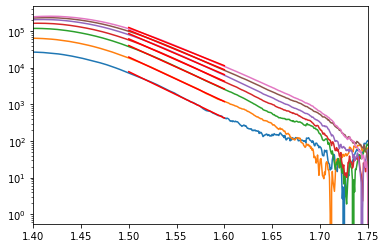

PS+P
10: 483.32275840303447
25: 472.7670778689809
50: 488.89104207536866
75: 510.0582681841251
100: 532.4087263282361
125: 558.068332516753
150: 586.405023243535


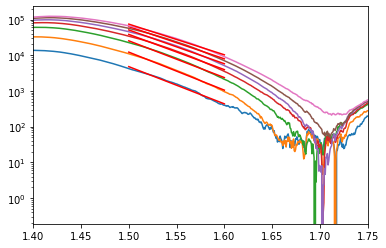

,TC_high,TC_del,TC_low
C,471.491306,34.423918,437.067388
C+B,553.380287,116.780160,436.600127
C+P,439.962120,44.083336,395.878784
CW,522.435627,90.904699,431.530928
NS,444.958817,35.722715,409.236101
NS+P,473.259779,98.627002,374.632777
P,512.551227,20.588649,491.962578
P+P,462.387672,51.499641,410.888031
PS,483.430423,69.012780,414.417644
PS+P,586.405023,113.637945,472.767078


In [150]:
##### TC ANALYSIS (LOG&TAIL) #####

kB = 8.6173324e-5 # eV/K 
# print(folderlist)

def func(x,a,b):
    return a*x+b

TC_del=pd.Series(index=folderlist,name='TC_del')
TC_high=pd.Series(index=folderlist,name='TC_high')
TC_low=pd.Series(index=folderlist,name='TC_low')

for s in folderlist:
    print(s)
    TCdf=pd.DataFrame()
    
    if s == 'C+B':
        e_llim=1.55
        e_ulim=1.65
    else:
        e_llim=1.5
        e_ulim=1.6
        
    for p in power:
        if pd.isna(flist[s][int(p)]):
            collection_pk.append(np.nan)
            collection_infl.append(np.nan)
            continue
        PLdata=pd.read_csv(path+s+'\\'+str(flist[s][int(p)]),header=None,names=['nm','intensity'],sep="\t")
        eph=1240/wav
        PLint=pd.Series(PLdata['intensity'],dtype=float)
        # rolling average smoothing + background subtracting
        PLint = PLint.iloc[:].rolling(window=50).mean().fillna(method='bfill')
        PLint = PLint.sub(PLint.min())

        eph_=[]
        PLint_=[]

        # defining fit limits
        for e in range(len(eph)):
            if eph[e]>e_llim and eph[e]<e_ulim:
                eph_.append(eph[e])
                PLint_.append(int(PLint[e]))

        # removing -infs
        TCdf[s]=np.log(PLint_)
        for q in range(len(TCdf[s])):
            if np.isneginf(TCdf[s][q]):
                TCdf[s][q]=0

        popt, pcov = curve_fit(func,eph_,TCdf[s])
        plt.semilogy(eph,PLint)
        tc=-1/(popt[0]*kB)
        print(str(p)+': '+str(tc))

        fit=[]
        for f in range(len(eph_)):
            fit.append(func(eph_[f],popt[0],popt[1]))
        plt.semilogy(eph_,np.exp(fit),'r-')
        plt.xlim(1.4,1.75)
        
        if p == power[1]:
            TC_low[s]=tc
        
        if p == power[-1]:
            TC_del[s]=tc-TC_low[s]
            TC_high[s]=tc
        
    plt.show()

TCmaster=pd.DataFrame()
TCmaster['TC_high']=TC_high
TCmaster['TC_del']=TC_del
TCmaster['TC_low']=TC_low
display(TCmaster)

TCmaster.to_csv(path+'TCparams.csv')


#         plt.savefig(path+s+'_TC_fit.png',dpi=300)


